 ### Introduction to Data Science - 2019.2

 ### Valter Moreno

 ### Homework 2: Predicting Schools Performance

 ### Data

 The data for this project was provided in four csv files containing information on shools in São Paulo metropolitan region.
 They were cleaned, transformed and saved in the Schools.csv file.

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="darkgrid")


In [35]:
# Reading the data into a dataframe

schools = pd.read_csv('Data/Schools.csv', encoding='utf-8')
schools.head()


,CD_ESCOLA,PARTICIPANTES,ENEM,CODMUN,CODDIST,LAB_INF,QD_ESP_C,QD_ESP_D,BIBLIO,REG_IN_CR,...,CLFUNDII_2015,CLFUNDI_2012,CLFUND_2012,CLFUND_2013,CLFUND_2014,CLFUND_2015,TOTAL_ALUNOS_2012,TOTAL_ALUNOS_2013,TOTAL_ALUNOS_2014,TOTAL_ALUNOS_2015
0,35054082,51,1,3550308,355030871,1,1,1,0,0,...,9.00,6.00,22.00,18.00,16.00,15.00,1171.00,1077.00,1061.00,1205.00
1,35060574,34,2,3550308,355030880,1,1,1,1,0,...,6.00,8.00,15.00,16.00,14.00,14.00,434.00,405.00,442.00,435.00
2,35070178,135,2,3550308,355030870,1,1,1,0,0,...,7.00,8.00,21.00,20.00,18.00,17.00,2051.00,1955.00,1887.00,1667.00
3,35071936,47,2,3550308,355030863,1,1,1,0,1,...,13.00,18.00,31.00,34.00,34.00,35.00,954.00,916.00,938.00,890.00
4,35100031,34,2,3550308,355030863,1,1,1,0,1,...,13.00,15.00,28.00,30.00,29.00,29.00,900.00,943.00,993.00,960.00


 As Scikit Learn expects continuous predictors, I will convert
 the INSE_CL to a set of dummy variables.

In [36]:
dummies = pd.get_dummies(schools.INSE_CL, prefix='INSE_CL')

schools.drop(['CD_ESCOLA', 'INSE_CL'], axis=1, inplace=True)
schools = schools.merge(dummies, left_index=True, right_index=True)


In [37]:
# Splitting the data into training and testing datasets

train, test = train_test_split(schools, test_size=0.2)

X = train.drop('ENEM', axis=1)
y = train.ENEM

Xtest = test.drop('ENEM', axis=1)
ytest = test.ENEM


 I will test several decision tree options to predict the classifiction
 of a school in ENEM 2015. All features in the 'sxhools' dataframe
 will be used as predictors.

 I will use cross-folding with 5 splits to train and test the model.

### Single decision tree

In [38]:
crossvalidation = KFold(n_splits=5, 
                        shuffle=True,
                        random_state=1)

for depth in range(1,10):
    tree_classifier = tree.DecisionTreeClassifier(
        max_depth=depth, random_state=0)
    if tree_classifier.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_classifier, 
                                    X, y, 
                                    scoring='accuracy', 
                                    cv=crossvalidation))
    print('Depth: %i Accuracy: %.3f' % (depth,score))
    

Depth: 1 Accuracy: 0.750
Depth: 2 Accuracy: 0.761
Depth: 3 Accuracy: 0.782
Depth: 4 Accuracy: 0.776
Depth: 5 Accuracy: 0.773
Depth: 6 Accuracy: 0.756
Depth: 7 Accuracy: 0.756
Depth: 8 Accuracy: 0.767
Depth: 9 Accuracy: 0.744


 To get an effective reduction and simplifiction,
 I will set the min_samples_split to 30 and avoid terminal leaves
 that are too small by setting min_samples_leaf to 10.

In [39]:
tree_classifier = tree.DecisionTreeClassifier(
    min_samples_split=30, 
    min_samples_leaf=10, 
    random_state=0)
tree_classifier.fit(X,y)
score = np.mean(cross_val_score(tree_classifier, X, y, 
                                scoring='accuracy', 
                                cv=crossvalidation))
print('Accuracy: %.3f' % score)


Accuracy: 0.790


 I will predict the values in the test dataset now.

In [40]:
tree_accuracy = tree_classifier.score(Xtest, ytest)

print('Accuracy on test data: %.3f' % tree_accuracy)
print('Confusion matrix:')
print(confusion_matrix(ytest, tree_classifier.predict(Xtest)))
    

Accuracy on test data: 0.724
Confusion matrix:
[[ 0  4  0  0]
 [ 0 57  2  1]
 [ 0 14  1  1]
 [ 0  1  1  5]]


### Bagging

I will start the analyisis using an arbitrary parameter configuration.

In [41]:
tree_classifier = DecisionTreeClassifier(random_state=0)
bagging = BaggingClassifier(tree_classifier, 
                            max_samples=0.7, 
                            max_features=0.7, 
                            n_estimators=300)
scores = np.mean(cross_val_score(bagging, X, y, 
                                 scoring='accuracy', 
                                 cv=crossvalidation))
print ('Accuracy: %.3f' % scores)


Accuracy: 0.816


I will vary the number of models in the tree to identify the
the optimum value.

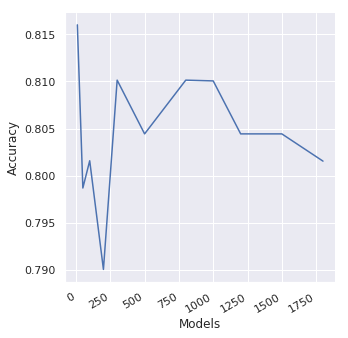

In [42]:
param_range = [10, 50, 100, 200, 300, 500, 800, 1000, 1200, 1500, 1800]
train_scores, test_scores = validation_curve(bagging, X, y,
                                  'n_estimators', 
                                  param_range=param_range, 
                                  cv=crossvalidation, 
                                  scoring='accuracy')
mean_test_scores = np.mean(test_scores, axis=1)

g = sns.relplot(x='Models', y='Accuracy',
                kind="line",
                data=pd.DataFrame({'Models': param_range,
                                   'Accuracy': mean_test_scores}))
g.fig.autofmt_xdate()


 Next, I will search for a better combination of hyperparameters to
 try to increase the accuracy of the model.

In [ ]:
search_grid = {'n_estimators':[50, 500, 1000, 1500],
               'max_samples':[0.6, 0.7, 0.8],
               'max_features':[0.6, 0.7, 0.8]}

search_func = GridSearchCV(estimator=bagging,
                           param_grid=search_grid,
                           scoring='accuracy',
                           cv=crossvalidation)
search_func.fit(X, y)
best_params = search_func.best_params_
best_score = search_func.best_score_
print('Best parameters: %s' % best_params)
print('Best accuracy: %.3f' % best_score)


 I will predict the values in the test dataset using the optimum
 parameters combination.

In [ ]:
tree_classifier = DecisionTreeClassifier(random_state=0)
bagging = BaggingClassifier(tree_classifier, 
                            max_samples=best_params['max_samples'], 
                            max_features=best_params['max_features'], 
                            n_estimators=best_params['n_estimators'])
bagging = bagging.fit(X,y)
bagging_accuracy = bagging.score(Xtest, ytest)

print('Accuracy on test data: %.3f' % bagging_accuracy)
print('Confusion matrix:')
print(confusion_matrix(ytest, bagging.predict(Xtest)))
    

### Random Forest

Again, I will start with an arbitrary parameters configuration.

In [ ]:
RF_cls = RandomForestClassifier(n_estimators=300,
                                random_state=1)
score = np.mean(cross_val_score(RF_cls, X, y, 
                                scoring='accuracy', 
                                cv=crossvalidation))
print('Accuracy: %.3f' % score) 


 I will repeat the analysis varying the number of models.

In [ ]:
train_scores, test_scores = validation_curve(RF_cls, X, y,
                                             'n_estimators',
                                             param_range=param_range,
                                             cv=crossvalidation, 
                                             scoring='accuracy')
mean_test_scores = np.mean(test_scores, axis=1)

g = sns.relplot(x='Models', y='Accuracy',
                kind="line",
                data=pd.DataFrame({'Models': param_range,
                                   'Accuracy': mean_test_scores}))
g.fig.autofmt_xdate()


 Next, I will search for a better combination of hyperparameters to
 try to increase the accuracy of the model.

In [ ]:
search_grid = {'n_estimators':[50, 100, 300],
               'max_features': [X.shape[1]//3, 'sqrt', 'log2', 'auto'], 
               'min_samples_leaf': [1, 10, 30]}

search_func = GridSearchCV(estimator=RF_cls,
                           param_grid=search_grid,
                           scoring='accuracy',
                           cv=crossvalidation)
search_func.fit(X, y)
best_params = search_func.best_params_
best_score = search_func.best_score_
print('Best parameters: %s' % best_params)
print('Best accuracy: %.3f' % best_score)


 I will use the best combination of parameters to predict
 the ENEM classification for schools in the test dataset.

In [ ]:
RF_cls = RandomForestClassifier(max_features=best_params['max_features'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_estimators=best_params['n_estimators'],
                                random_state=1)
RF_cls = RF_cls.fit(X,y)
rf_accuracy = RF_cls.score(Xtest, ytest)

print('Accuracy on test data: %.3f' % rf_accuracy)
print('Confusion matrix:')
print(confusion_matrix(ytest, RF_cls.predict(Xtest)))
    

### Boosting
 In this last step, I will use two boosting applications, adaboost
 and gradient boosting machines, to predict a school's classification
 in ENEM 2015.

#### Adaboost
 First, I will train a model with a basic arbitrary parameter
 configuration.

In [ ]:
ada = AdaBoostClassifier(n_estimators=1000, 
                         learning_rate=0.01, 
                         base_estimator=DecisionTreeClassifier(max_depth=1),
                         random_state=1)
crossvalidation = KFold(n_splits=5, shuffle=True, 
                        random_state=1)
score = np.mean(cross_val_score(ada, X, y, 
                                scoring='accuracy', 
                                cv=crossvalidation))
print('Accuracy: %.3f' % score)


 To try to improve the accuracy of the model, I will
 explore variations in the number of estimators.

In [ ]:
param_range = [100, 500, 1000, 1250, 1500, 2000, 2500]
train_scores, test_scores = validation_curve(ada, X, y,
                                             'n_estimators',
                                             param_range=param_range,
                                             cv=crossvalidation, 
                                             scoring='accuracy')
mean_test_scores = np.mean(test_scores, axis=1)

g = sns.relplot(x='Models', y='Accuracy',
                kind="line",
                data=pd.DataFrame({'Models': param_range,
                                   'Accuracy': mean_test_scores}))
g.fig.autofmt_xdate()


 I will search for a better combination of number of estimators
 and learning rate to further increase the accuracy of
 the model.

In [ ]:
search_grid = {'n_estimators': [1000, 1500, 1800, 2000, 2500],
               'learning_rate': [0.01, 0.02, 0.03]}

search_func = GridSearchCV(estimator=ada,
                           param_grid=search_grid,
                           scoring='accuracy',
                           cv=crossvalidation)
search_func.fit(X, y)
best_params = search_func.best_params_
best_score = search_func.best_score_
print('Best parameters: %s' % best_params)
print('Best accuracy: %.3f' % best_score)


 The best combination of parameters will be used to predict
 the values of ENEM classification in the test dataset.

In [ ]:
ada = AdaBoostClassifier(n_estimators=best_params['n_estimators'], 
                         learning_rate=best_params['learning_rate'], 
                         base_estimator=DecisionTreeClassifier(max_depth=1),
                         random_state=1)
ada = ada.fit(X,y)
ada_accuracy = ada.score(Xtest, ytest)

print('Accuracy on test data: %.3f' % ada_accuracy)
print('Confusion matrix:')
print(confusion_matrix(ytest, ada.predict(Xtest)))


#### Gradient Boosting Classifier
 Next, I will fit a gradient boosting classifier with an initial
 parameter setting.

In [ ]:
crossvalidation = KFold(n_splits=5, 
                        shuffle=True, 
                        random_state=1)

GBC = GradientBoostingClassifier(n_estimators=300, 
                                 subsample=1.0, 
                                 max_depth=3, 
                                 learning_rate=0.1, 
                                 random_state=1)
score = np.mean(cross_val_score(GBC, X, y, 
                                scoring='accuracy', 
                                cv=crossvalidation))
print('Accuracy: %.3f' % score)


 I will explore combinations of the parameters of the model to
 try to improve its accuracy.

In [ ]:
search_grid =  {'subsample': [1.0, 0.9], 
                'max_depth': [2, 3, 5], 
                'n_estimators': [250, 500 , 1000, 1500],
                'learning_rate': [0.1, 0.2, 0.3],}
search_func = GridSearchCV(estimator=GBC,
                           param_grid=search_grid,
                           scoring='accuracy',
                           cv=crossvalidation)
search_func.fit(X,y)

best_params = search_func.best_params_
best_score = abs(search_func.best_score_)
print('Best parameters: %s' % best_params)
print('Best mean squared error: %.3f' % best_score)


 The best combination of parameters will be used to predict the
 classification in ENEM for the schools in the test dataset.

In [ ]:
GBC = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], 
                                 subsample=best_params['subsample'], 
                                 max_depth=best_params['max_depth'], 
                                 learning_rate=best_params['learning_rate'], 
                                 random_state=1)
GBC = GBC.fit(X,y)
gb_accuracy = GBC.score(Xtest, ytest)

print('Accuracy on test data: %.3f' % gb_accuracy)
print('Confusion matrix:')
print(confusion_matrix(ytest, GBC.predict(Xtest)))


## Conclusion
 Here are the accuracy for each of the models previously fitted to
 the test data:

In [ ]:
print('Decision tree:     %.3f' % tree_accuracy)
print('Bagging:           %.3f' % bagging_accuracy)
print('Random forest:     %.3f' % rf_accuracy)
print('Adaboost:          %.3f' % ada_accuracy)
print('Gradient boosting: %.3f' % tree_accuracy)